# Compute generation drought thresholds

This notebook completes the first step in identifying days with low energy generation (resource generation drought days) from the resource generation projections, by calculating the threshold below which a day will be considered a low generation day. 

The threshold utilizes a Standardized Energy Index definition based on the methodologies in Allen and Otero (2023) (https://www.sciencedirect.com/science/article/pii/S0960148123011217)

Low generation (energy drought) days are defined as days that fall below the 10th percentile of historical generation for that particular grid cell. Historical data is taken from the same time of year (within a 60 day window) to normalize for the seasonal cycle.

This means that low generation days are defined relative to expected generation for a given location and time of year.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF 
import xarray as xr
import matplotlib.pyplot as plt

import time
from renewable_data_load import *

# Configure dask for parallel execution
import dask
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers to your CPU cores

## Set parameters

Modify these variables to adjust which renewable type the thresholds are being calculated for

In [ ]:
resource = "windpower"
module = "onshore"
domain = "d02"

reference_gwl = 0.8
window_size = 60

## Load data, compute thresholds, and save

Thresholds are saved as separate intermediate files for the next step of calculating energy droughts

In [ ]:

for simulation in ["mpi-esm1-2-hr","miroc6","taiesm1","ec-earth3"]:
    variable = "cf"
    frequency = "day"
    start_time = time.time()
    print(f"Processing simulation: {simulation}")
    ren_ds = get_ren_data_concat(resource, module, domain, variable, frequency, simulation)

    #### SUBSET FOR TESTING ####
    #ren_ds = ren_ds.isel(y=slice(222,226), x=slice(53,57)) # Small slice for testing

    # Get bounds for reference GWL period
    WRF_sim_name = sim_name_dict[simulation]
    model = WRF_sim_name.split("_")[1]
    ensemble_member = WRF_sim_name.split("_")[2]
    start_year, end_year = get_gwl_crossing_period(model, ensemble_member, reference_gwl)

    # Extract reference periods
    ds_reference = ren_ds.sel(time=slice(f"{start_year}", f"{end_year}"))

    ds_window = ds_reference.rolling(time=window_size, center=True).construct("window")
    ds_window = ds_window.assign_coords({"window" : [w for w in np.arange(1,window_size+1,1)]})
    ds_window['dayofyear'] = ds_window.time.dt.dayofyear
    ds_window['year'] = ds_window.time.dt.year
    ds_window = ds_window.assign_coords(
        {"dayofyear":ds_window.time.dt.dayofyear,
        "year":ds_window.time.dt.year}
    )
    # reshape time dimension
    ds_window = ds_window.drop_vars("time").set_index(time=['dayofyear','year']).unstack()

    # flatten each day of year to a 1d vector with all samples (30 day window x number of years)
    ds_window = ds_window.stack(sample=["window","year"])
    ds_window = ds_window.rename("reference_gen")

    # Compute 10th percentile across samples for each day-of-year
    percentile_10 = ds_window.quantile(0.1, dim='sample')

    percentile_10 = percentile_10.load()

    output_path = f"../../data/thresholds/{resource}_{module}_{domain}_{variable}_{simulation}_gwlref{reference_gwl}_10th_pctile.nc"
    percentile_10.to_netcdf(output_path)
    print(f"Saved 10th percentile data to: {output_path}")
    end_time = time.time()
    duration_mins = (end_time - start_time) / 60
    print(f"Completed processing for {simulation} in {duration_mins:.2f} minutes.\n")

    # Close datasets to free up memory
    ren_ds.close()
    ds_reference.close()
    ds_window.close()
    percentile_10.close()

Processing simulation: mpi-esm1-2-hr


/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


Saved 10th percentile data to: ../data/thresholds/windpower_offshore_d03_cf_mpi-esm1-2-hr_gwlref0.8_10th_pctile.nc
Completed processing for mpi-esm1-2-hr in 14.95 minutes.

Processing simulation: miroc6


/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


Saved 10th percentile data to: ../data/thresholds/windpower_offshore_d03_cf_miroc6_gwlref0.8_10th_pctile.nc
Completed processing for miroc6 in 69.23 minutes.

Processing simulation: taiesm1


/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


Saved 10th percentile data to: ../data/thresholds/windpower_offshore_d03_cf_taiesm1_gwlref0.8_10th_pctile.nc
Completed processing for taiesm1 in 44.13 minutes.



In [16]:
test_ds = drought_ds

## Visualization: Full Time Series at Test Location

In [ ]:
ren_ds = get_ren_data_concat('windpower', 'onshore', 'd02', 'cf', 'day', 'mpi-esm1-2-hr')


In [18]:
reference_gwl = 0.8

In [19]:
# Get bounds for reference GWL period
WRF_sim_name = sim_name_dict["mpi-esm1-2-hr"]
model = WRF_sim_name.split("_")[1]
ensemble_member = WRF_sim_name.split("_")[2]
start_year, end_year = get_gwl_crossing_period(model, ensemble_member, reference_gwl)

# Extract reference periods
ds_reference = ren_ds.sel(time=slice(f"{start_year}", f"{end_year}"))

In [24]:
window_size = 60

In [30]:
ds_window = ds_reference.rolling(time=window_size, center=True).construct("window")
ds_window = ds_window.assign_coords({"window" : [w for w in np.arange(1,window_size+1,1)]})
ds_window['dayofyear'] = ds_window.time.dt.dayofyear
ds_window['year'] = ds_window.time.dt.year
ds_window = ds_window.assign_coords(
    {"dayofyear":ds_window.time.dt.dayofyear,
    "year":ds_window.time.dt.year}
)
# reshape time dimension
ds_window = ds_window.drop_vars("time").set_index(time=['dayofyear','year']).unstack()

# flatten each day of year to a 1d vector with all samples (30 day window x number of years)
ds_window = ds_window.stack(sample=["window","year"])
ds_window = ds_window.rename("reference_gen")

# Compute 10th percentile across samples for each day-of-year
percentile_10 = ds_window.quantile(0.1, dim='sample')


In [26]:
ds_window

<xarray.DataArray 'reference_gen' (y: 320, x: 250, dayofyear: 365, sample: 1800)> Size: 420GB
dask.array<reshape, shape=(320, 250, 365, 1800), dtype=float64, chunksize=(10, 6, 121, 1800), chunktype=numpy.ndarray>
Coordinates:
  * y                  (y) float64 3kB -2.441e+05 -2.351e+05 ... 2.627e+06
  * x                  (x) float64 2kB -4.638e+06 -4.629e+06 ... -2.397e+06
  * dayofyear          (dayofyear) int64 3kB 1 2 3 4 5 6 ... 361 362 363 364 365
  * sample             (sample) object 14kB MultiIndex
    Lambert_Conformal  int32 4B 1
    landmask           (y, x) float32 320kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 320kB 23.35 23.39 23.43 ... 56.42 56.46
    lon                (y, x) float32 320kB -116.5 -116.4 ... -111.6 -111.5
  * window             (sample) int64 14kB 1 1 1 1 1 1 1 ... 60 60 60 60 60 60
  * year               (sample) int64 14kB 1981 1982 1983 ... 2008 2009 2010
Attributes:
    data_type:             Gridded
    extended_description:  Ratio of power generated to turbine nameplate capa...
    frequency:             day
    grid_mapping:          Lambert_Conformal
    long_name:             capacity factor
    units:                 1

<xarray.DataArray 'reference_gen' (y: 320, x: 250, dayofyear: 365)> Size: 234MB
dask.array<getitem, shape=(320, 250, 365), dtype=float64, chunksize=(10, 6, 121), chunktype=numpy.ndarray>
Coordinates:
  * y          (y) float64 3kB -2.441e+05 -2.351e+05 ... 2.618e+06 2.627e+06
  * x          (x) float64 2kB -4.638e+06 -4.629e+06 ... -2.406e+06 -2.397e+06
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
    landmask   (y, x) float32 320kB 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    lat        (y, x) float32 320kB 23.35 23.39 23.43 ... 56.38 56.42 56.46
    lon        (y, x) float32 320kB -116.5 -116.4 -116.3 ... -111.6 -111.5
    quantile   float64 8B 0.5
Attributes:
    data_type:             Gridded
    extended_description:  Ratio of power generated to turbine nameplate capa...
    frequency:             day
    grid_mapping:          Lambert_Conformal
    long_name:             capacity factor
    units:                 1

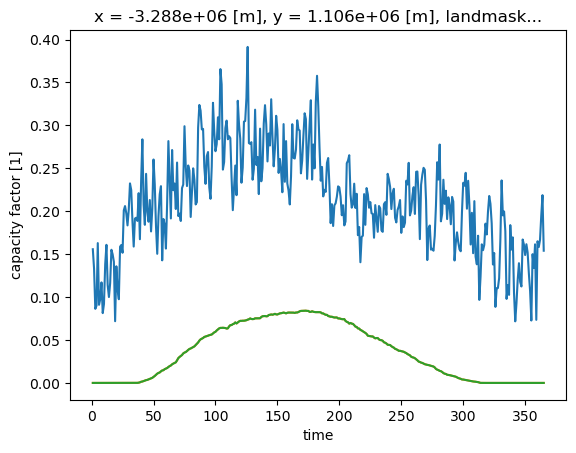

In [31]:
ds_reference.isel(x=150,y=150).groupby('time.dayofyear').mean().plot()

test_ds.reference_gen.isel(x=150,y=150).plot()

percentile_10.isel(x=150,y=150).plot()

In [22]:
test_ds.reference_gen.isel(x=150,y=150).values

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.33333324e-05, 2.91666656e-04, 6.62499992e-04, 1.37499999e-03,
       1.62500003e-03, 2.19999992e-03, 2.79166666e-03, 3.23333340e-03,
       3.53750011e-03, 4.12083333e-03, 4.65833317e-03, 5.32083330e-03,
       5.91250001e-03, 6.94999998e-03, 8.10833303e-03, 9.52083366e-03,
       1.07750001e-02, 1.16208335e-02, 1.21958332e-02, 1.34791669e-02,
      

In [6]:
test_ds = xr.open_dataset("../../data/thresholds/windpower_onshore_d02_cf_mpi-esm1-2-hr_gwlref0.8_10th_pctile.nc")

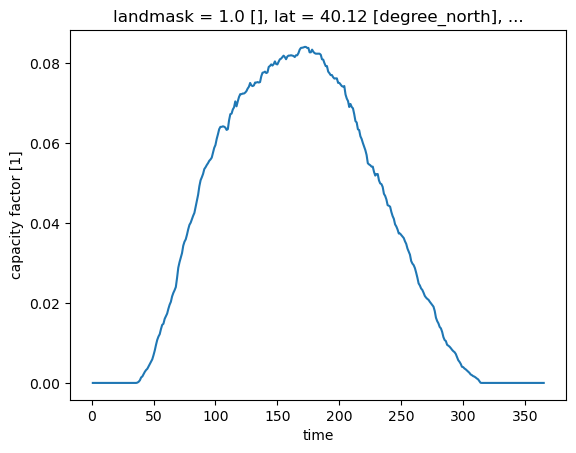